In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from scipy import optimize
from matplotlib.colors import LinearSegmentedColormap
import math

matplotlib.rc('font', size=16)

# adsorption model $\mathbf{m}(\mathbf{p})$

In [2]:
# Langmuir params for MOF 1
K1 = [0.1, 0.5]
M1 = 1.0
# Langmuir params for MOF 2
K2 = [0.7, 0.3]
M2 = 2.0

def m_1(p):
    return M1 * np.dot(K1, p) / (1 + np.dot(K1, p))

def m_2(p):
    return M2 * np.dot(K2, p) / (1 + np.dot(K2, p))

In [118]:
p = np.array([1.2, -3])
np.any(p < 0) 
m_1(p)

3.6315789473684217

# inverse of adsorption model $\mathbf{p}(\mathbf{m})$

In [4]:
def p_of_m(m_0, p_lb, p_ub): 
    # we want this function to return a zero vector
    #  it takes in a pressure p
    #  it outputs the corresponding difference between the response and the response m_0 that we find
    #  if we find the right p that gives us the response m_0, then this will be the zero vector
    def f(p):
        return [m_1(p) - m_0[0], m_2(p) - m_0[1]]
    sol = optimize.root(f, [1.0, 1.0])
    p = sol.x
    # return nan if p less than lower bound, greater than upper bound
    if p[0] < p_lb or p[1] < p_lb or p[0] > p_ub or p[1] > p_ub:
        return np.array([np.nan, np.nan])
    if not sol.success:
        return np.array([np.nan, np.nan])
#     assert np.all(np.isclose([m_1(p), m_2(p)], m_0))
    return p

p_of_m([0.2, 0.5], 0, 5)

array([0.28645833, 0.44270833])

In [5]:
def get_meshgrid(x_max, y_max, nb_pts=200):
    return np.meshgrid(np.linspace(0, x_max, num=nb_pts),
                       np.linspace(0, y_max, num=nb_pts))

In [6]:
def colorFromBivariateData(x,y,cmap1 = plt.cm.Greens, cmap2 = plt.cm.YlOrRd):
    if np.any(x > 1) or np.any(y > 1):
        raise Exception("Numbers must be between 0 and 1.")
    if np.any(np.isnan(x)) or np.any(np.isnan(y)):
        return np.array([1, 1, 1, 1])
    x_color = cmap1(x)
    y_color = cmap2(y)

    # Color for each point
    xy_color = np.sum([x_color, y_color], axis=0)/2.0

    return xy_color

In [7]:
colorFromBivariateData(2,2)

Exception: Numbers must be between 0 and 1.

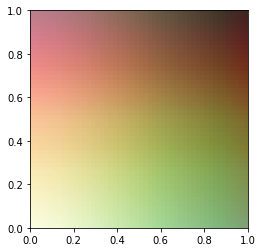

In [8]:
x = np.linspace(0, 1)
y = np.linspace(0, 1)
z = [[colorFromBivariateData(x[i], y[j]) for i in range(np.size(x))] for j in range(np.size(y))]
extent = (0, 1, 0, 1) #figure out how to put our desired x/y lims on this
plt.imshow(z, extent=extent, origin='lower')


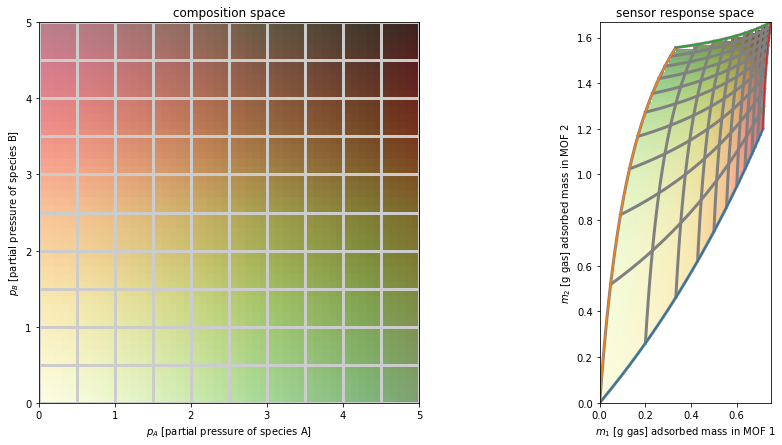

In [112]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].set_title("composition space")
ax[0].set_xlabel("$p_A$ [partial pressure of species A]")
ax[0].set_ylabel("$p_B$ [partial pressure of species B]")

# shared params
p_max = 5.0 # largest pressure we go to.

###
#   sensor response space
###
ax[1].set_aspect('equal', 'box')
ax[1].set_title("sensor response space")
ax[1].set_xlabel("$m_1$ [g gas] adsorbed mass in MOF 1")
ax[1].set_ylabel("$m_2$ [g gas] adsorbed mass in MOF 2")

###
#   draw grid lines and their mapping
###
dp = 0.5 # spacing between grid lines
nb_pts = 50
# these arrays will contain the correponding reponses to each point on the lines.
m1 = np.zeros(nb_pts)
m2 = np.zeros(nb_pts)
for i in range(int(p_max / dp)+1):
    ###
    #   x = constant (vertical) grid lines
    ###
    p_a = i * dp # p_a is constant here.
    # plot the line in composition space
    ax[0].plot([p_a, p_a], [0, p_max], color="0.8", lw=3)
    
    # plot the image of the line in sensor response space
    p_b = np.linspace(0.0, p_max, nb_pts)

    # loop through points on the line
    for j in range(nb_pts):
        # get vector on this line
        p_on_line = np.array([p_a, p_b[j]])
        # compute the adsorbed mass in the two MOFs when exposed to this gas composition
        m1[j] = m_1(p_on_line)
        m2[j] = m_2(p_on_line)
    ax[1].plot(m1, m2, color="gray", lw=3)
    
    ###
    #   y = constant (horizontal) grid lines
    ###
    p_b = i * dp # p_b is constant here.
    # plot the line in composition space
    ax[0].plot([0, p_max], [p_b, p_b], color="0.8", lw=3)
    
    # plot the image of the line in sensor response space
    p_a = np.linspace(0.0, p_max, nb_pts)

    # loop through points on the line
    for j in range(nb_pts):
        # get vector on this line
        p_on_line = np.array([p_a[j], p_b])
        # compute the adsorbed mass in the two MOFs when exposed to this gas composition
        m1[j] = m_1(p_on_line)
        m2[j] = m_2(p_on_line)
    ax[1].plot(m1, m2, color="gray", lw=3)
        
###
#   color the plane
#   color represents.
###

# Initialize pa, pb for colormap
pa = np.linspace(0, p_max)
pb = np.linspace(0, p_max)

# Create bivariate colormap for composition space
z_composition = [[colorFromBivariateData(pa[i]/p_max, pb[j]/p_max) for i in range(np.size(pa))] for j in range(np.size(pb))]

# find max mass
m_max = [m_1([p_max,p_max]), m_2([p_max,p_max])]

# Initialize m1, m2 for colormap
num_grid_pts = 100
m1_grid = np.linspace(0, m_max[0], num_grid_pts)
m2_grid = np.linspace(0, m_max[1], num_grid_pts)

# initialize response space colormap, 
z_response = [[colorFromBivariateData(0, 0) for i in range(num_grid_pts)] for j in range(num_grid_pts)]

# Modify bivariate colormap for response space based on mapping from composition space 
for i in range(num_grid_pts):
    for j in range(num_grid_pts):
        m_0 = [m1_grid[i], m2_grid[j]]
        p = p_of_m(m_0, 0, p_max) 
        z_response[j][i] = colorFromBivariateData(p[0]/p_max, p[1]/p_max)

# Create extent of colormaps
extent_composition = (0, p_max, 0, p_max) 
extent_response = (0, m_max[0], 0, m_max[1])

# Plot colormaps in composition and response space
ax[0].imshow(z_composition, extent=extent_composition, origin='lower')        
ax[1].imshow(z_response, extent=extent_response,  origin='lower') # need to figure out how to map extent to grid lines
ax[1].set_aspect('equal', 'box')
ax[0].set_aspect('equal', 'box')

draw_mspace_boundaries(p_max, 1)

In [10]:
m_max
int(m_max[1] / 0.1)+1

17

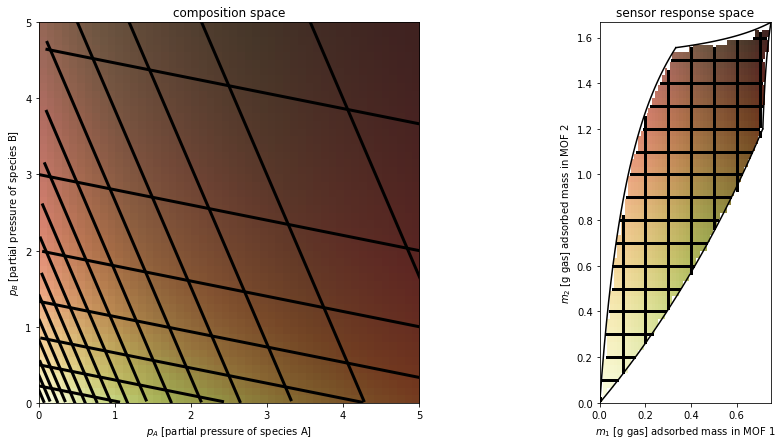

In [115]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].set_title("composition space")
ax[0].set_xlabel("$p_A$ [partial pressure of species A]")
ax[0].set_ylabel("$p_B$ [partial pressure of species B]")
# set composition space to exclude negative pressures 
ax[0].set_xlim(xmin=0, xmax=p_max)
ax[0].set_ylim(ymin=0, ymax=p_max)

#using m_max from cell above (also using other variable from above)

###
#   sensor response space
###
ax[1].set_aspect('equal', 'box')
ax[1].set_title("sensor response space")
ax[1].set_xlabel("$m_1$ [g gas] adsorbed mass in MOF 1")
ax[1].set_ylabel("$m_2$ [g gas] adsorbed mass in MOF 2")

###
#   color the plane
#   color represents.
###

# Initialize m1, m2 for colormap
m1 = np.linspace(0, m_max[0])
m2 = np.linspace(0, m_max[1])

# Create bivariate colormap for response space
z_response = [[colorFromBivariateData(m1[i]/m_max[0], m2[j]/m_max[1]) for i in range(np.size(m1))] 
                 for j in range(np.size(m2))]

# Modify response space colormap to only have color where presssure is positive
for i in range(np.shape(z_response)[0]):
    for j in range(np.shape(z_response)[1]):
        m_0 = [m1[i], m2[j]]
        p = p_of_m(m_0, 0, np.Inf) 
        # zero out (i.e. set color to white) responses that correspond to negative pressures
        if np.any(np.isnan(p)) or np.any(p > p_max):
            z_response[j][i] = np.array([1, 1, 1, 1])
            
# Plot colormap on response space 
ax[1].imshow(z_response, extent=extent_response,  origin='lower')           
ax[1].set_aspect('equal', 'box')
ax[0].set_aspect('equal', 'box')    
    
# Create bivariate colormap for composition space based on mapping from response space 
for i in range(np.shape(z_composition)[0]):
    for j in range(np.shape(z_composition)[1]):
        p_0 = np.array([pa[i], pb[j]])
        m = np.array([m_1(p_0), m_2(p_0)])
        # zero out (responses that are above m_max
        if np.any(m > m_max):
            z_composition[i][j] = np.array([1, 1, 1, 1])
        else:
            z_composition[i][j] = colorFromBivariateData(m[0]/m_max[0], m[1]/m_max[1])   

# Plot colormap on composition space
ax[0].imshow(z_composition, extent=extent_composition, origin='lower')        

# get spaces where it goes from white to color or color to white (up, down)
w_to_c = []
c_to_w = []
for j in range(len(z_response)):
    for i in range(len(z_response[j])-1):
        # white to color
        if (np.array_equal(z_response[i][j], np.array([1,1,1,1])) and not np.array_equal(z_response[i+1][j], np.array([1,1,1,1]))):
            w_to_c.append([(i,j), (i+1,j)])
        # color to white
        elif (not np.array_equal(z_response[i][j], np.array([1,1,1,1])) and np.array_equal(z_response[i+1][j], np.array([1,1,1,1]))):
            c_to_w.append([(i,j), (i+1,j)])
            
            
# get spaces where it goes from white to color or color to white (side to side)
w_to_c_sts = []
c_to_w_sts = []
for i in range(len(z_response)):
    for j in range(len(z_response[i])-1):
        # white to color
        if (np.array_equal(z_response[i][j], np.array([1,1,1,1])) and not np.array_equal(z_response[i][j+1], np.array([1,1,1,1]))):
            w_to_c_sts.append([(i,j), (i,j+1)])
        # color to white
        elif (not np.array_equal(z_response[i][j], np.array([1,1,1,1])) and np.array_equal(z_response[i][j+1], np.array([1,1,1,1]))):
            c_to_w_sts.append([(i,j), (i,j+1)])            

###
#   draw grid lines and their mapping
###
dm = 0.1 # spacing between grid lines
nb_pts = 50
# these arrays will contain the correponding compositions to each point on the lines.
p_a = np.zeros(nb_pts)
p_b = np.zeros(nb_pts)

# calculate the spacing between each colored square
Δm1 = m_max[0]/len(z_response)
Δm2 = m_max[1]/len(z_response[0])
# gives corresponding range/unit from colormap (of len 50) to figure len (.75) (i.e. x axis)
m1_increments = np.linspace(0, m_max[0], num=len(z_response))
# gives corresponding range/unit from colormap (of len 50) to figure len (1.667) (i.e. y axis)
m2_increments = np.linspace(0, m_max[1], num=len(z_response[0]))

for i in range(int(m_max[1] / dm)+1):
    ###
    #   x = constant (vertical) grid lines
    ###
    m1 = i * dm # m1 is constant here.

    if m1 < m_max[0]:
        # gets index from m1_increment that approx. matches where the grid line will be drawn
        for j in range(len(m1_increments)):
            if math.isclose(m1_increments[j], m1, abs_tol=10**-2):
                m1_val_for_lines = j
                break
            
        # gets point where grid line should begin (where it goes from white to color)
        for k in range(len(w_to_c)):
            if m1_val_for_lines is w_to_c[k][0][1]:
                begin_black = w_to_c[k][1][0] * Δm2 
                break
            else: begin_black = 0
       
        # gets point where grid line should end (where it goes from color to white)
        for k in range(len(c_to_w)):
            if m1_val_for_lines is c_to_w[k][0][1]:
                end_black = c_to_w[k][1][0] * Δm2  
                
                
        # plot the line in response space
        ax[1].plot([m1, m1], [0, begin_black], color="white", lw=3)  
        ax[1].plot([m1, m1], [begin_black, end_black], color="black", lw=3)  
        ax[1].plot([m1, m1], [end_black, m_max[1]], color="white", lw=3)  

    
        # plot the image of the line in composition space
        m2 = np.linspace(0.0, m_max[1], nb_pts)

        # loop through points on the line
        for j in range(nb_pts):
            # get vector on this line
            m_on_line = np.array([m1, m2[j]])
            # compute the composition in the gas space when MOFs have this much gas absorbed
            p_a[j], p_b[j] = p_of_m(m_on_line, 0, np.Inf) 
        ax[0].plot(p_a, p_b, color="black", lw=3)

    ###
    #   y = constant (horizontal) grid lines
    ###
    m2 = i * dm # m2 is constant here.

    if m2 < m_max[1]:
        # gets index from m1_increment that approx. matches where the grid line will be drawn
        for j in range(len(m2_increments)):
            #if math.isclose(m2_increments[j], m1, abs_tol=10**-2):
            if math.isclose(math.floor((m2_increments[j] * 10))/10, m2, rel_tol=1e-2):
                m2_val_for_lines = j
                break
            
        # gets point where grid line should begin (where it goes from white to color)
        for k in range(len(w_to_c_sts)):
            if m2_val_for_lines is w_to_c_sts[k][0][0]:
                m2_begin_black = w_to_c_sts[k][1][1] * Δm1 
                break
                
        # gets point where grid line should end (where it goes from color to white)
        for k in range(len(c_to_w_sts)):
            if m2_val_for_lines is c_to_w_sts[k][0][0]:
                m2_end_black = c_to_w_sts[k][1][1] * Δm1   
                break

        # plot the line in composition space
        ax[1].plot([0, m2_begin_black], [m2, m2], color="white", lw=3)
        ax[1].plot([m2_begin_black, m2_end_black], [m2, m2], color="black", lw=3)
        ax[1].plot([m2_end_black, m_max[0]], [m2, m2], color="white", lw=3)

        # plot the image of the line in composition space
        m1 = np.linspace(0.0, m_max[0], nb_pts)
    
        # loop through points on the line
        for j in range(nb_pts):
            # get vector on this line
            m_on_line = np.array([m1[j], m2])
            # compute the composition in the gas space when MOFs have this much gas absorbed
            p_a[j], p_b[j] = p_of_m(m_on_line, 0, np.Inf) 
        ax[0].plot(p_a, p_b, color="black", lw=3)
    
# TODO 
# Add boarder around response space


draw_mspace_boundaries(p_max, 1) 

In [114]:
def is_valid(m1, m2, p_max=5):
    return #true or false if pressure is inside composition box

def draw_vert_line(x, y_min, y_max):
    return
    
def draw_horizontal_line(y, x_min, x_max):
    return

def valid_m2(m1): #find valid m2 value range for m1 
    return m2_min, m2_max

def valid_m1(m2): #find valid m1 value range for m2 
    return m1_min, m1_max

def draw_mspace_boundaries(p_max, plt_num):
    x = np.linspace(0, p_max) 
    m1 = np.zeros(len(x))
    m2 = np.zeros(len(x))
    for i in range(len(x)):
        # make pa = 0
        p = [0, x[i]]
        m1[i] = m_1(p) 
        m2[i] = m_2(p)
    ax[plt_num].plot(m1,m2, color="black")
    for i in range(len(x)):        
        # make pb = 0
        p = [x[i], 0]
        m1[i] = m_1(p) 
        m2[i] = m_2(p)
    ax[plt_num].plot(m1,m2,color="black")
    for i in range(len(x)):        
        # make pa = max
        p = [p_max, x[i]]
        m1[i] = m_1(p) 
        m2[i] = m_2(p)
    ax[plt_num].plot(m1,m2,color="black")
    for i in range(len(x)):        
        # make pb = max
        p = [x[i], p_max]
        m1[i] = m_1(p) 
        m2[i] = m_2(p)
    ax[plt_num].plot(m1,m2,color="black")

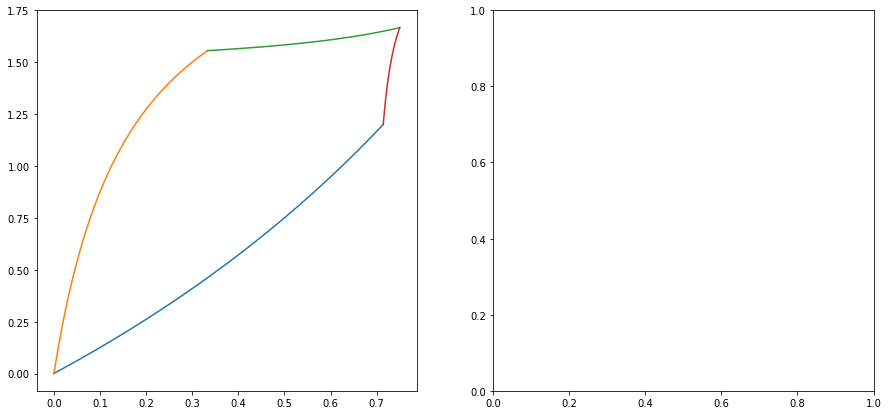

In [110]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
draw_mspace_boundaries(p_max, 0)

In [76]:
print(m2_increments)
m_test_nums = [0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 
               0.8, 0.9, 1.0, 1.1, 1.2000000000000002, 1.3, 1.4000000000000001, 1.5, 1.6]
for j in range(len(m2_increments)):
        #print(math.floor((m2_increments[j] * 10))/10)
        if math.isclose(math.floor((m2_increments[j] * 10))/10, m_test_nums[7], rel_tol=1e-2):
            print(j, m2_increments[j])
            m2_val_for_lines = j
            break

[0.         0.03401361 0.06802721 0.10204082 0.13605442 0.17006803
 0.20408163 0.23809524 0.27210884 0.30612245 0.34013605 0.37414966
 0.40816327 0.44217687 0.47619048 0.51020408 0.54421769 0.57823129
 0.6122449  0.6462585  0.68027211 0.71428571 0.74829932 0.78231293
 0.81632653 0.85034014 0.88435374 0.91836735 0.95238095 0.98639456
 1.02040816 1.05442177 1.08843537 1.12244898 1.15646259 1.19047619
 1.2244898  1.2585034  1.29251701 1.32653061 1.36054422 1.39455782
 1.42857143 1.46258503 1.49659864 1.53061224 1.56462585 1.59863946
 1.63265306 1.66666667]
21 0.7142857142857143


In [67]:
math.isclose(round(0.123,1), round(0.14,1), abs_tol=10**-2)
math.floor(0.13 * 10) / 10

0.1

In [80]:
w_to_c = []
c_to_w = []
for j in range(len(z_response)):
    for i in range(len(z_response[j])-1):
        if (np.array_equal(z_response[i][j], np.array([1,1,1,1])) and not np.array_equal(z_response[i+1][j], np.array([1,1,1,1]))):
            w_to_c.append([(i,j), (i+1,j)])
        elif (not np.array_equal(z_response[i][j], np.array([1,1,1,1])) and np.array_equal(z_response[i+1][j], np.array([1,1,1,1]))):
            c_to_w.append([(i,j), (i+1,j)])
print("white to color: ", w_to_c)
print("color to white", c_to_w)

white to color:  [[(0, 1), (1, 1)], [(0, 2), (1, 2)], [(0, 3), (1, 3)], [(0, 4), (1, 4)], [(0, 5), (1, 5)], [(1, 6), (2, 6)], [(1, 7), (2, 7)], [(1, 8), (2, 8)], [(1, 9), (2, 9)], [(1, 10), (2, 10)], [(2, 11), (3, 11)], [(2, 12), (3, 12)], [(2, 13), (3, 13)], [(2, 14), (3, 14)], [(3, 15), (4, 15)], [(3, 16), (4, 16)], [(3, 17), (4, 17)], [(3, 18), (4, 18)], [(4, 19), (5, 19)], [(4, 20), (5, 20)], [(4, 21), (5, 21)], [(5, 22), (6, 22)], [(5, 23), (6, 23)], [(5, 24), (6, 24)], [(6, 25), (7, 25)], [(6, 26), (7, 26)], [(7, 27), (8, 27)], [(7, 28), (8, 28)], [(7, 29), (8, 29)], [(8, 30), (9, 30)], [(8, 31), (9, 31)], [(9, 32), (10, 32)], [(10, 33), (11, 33)], [(10, 34), (11, 34)], [(11, 35), (12, 35)], [(12, 36), (13, 36)], [(12, 37), (13, 37)], [(13, 38), (14, 38)], [(14, 39), (15, 39)], [(15, 40), (16, 40)], [(16, 41), (17, 41)], [(17, 42), (18, 42)], [(18, 43), (19, 43)], [(19, 44), (20, 44)], [(20, 45), (21, 45)], [(25, 46), (26, 46)], [(36, 47), (37, 47)], [(44, 48), (45, 48)]]
color t

In [33]:
print(w_to_c_sts)

[[(1, 0), (1, 1)], [(2, 1), (2, 2)], [(3, 1), (3, 2)], [(4, 2), (4, 3)], [(5, 2), (5, 3)], [(6, 3), (6, 4)], [(7, 3), (7, 4)], [(8, 4), (8, 5)], [(9, 5), (9, 6)], [(10, 5), (10, 6)], [(11, 6), (11, 7)], [(12, 6), (12, 7)], [(13, 7), (13, 8)], [(14, 8), (14, 9)], [(15, 8), (15, 9)], [(16, 9), (16, 10)], [(17, 10), (17, 11)], [(18, 10), (18, 11)], [(19, 11), (19, 12)], [(20, 12), (20, 13)], [(21, 13), (21, 14)], [(22, 13), (22, 14)], [(23, 14), (23, 15)], [(24, 15), (24, 16)], [(25, 15), (25, 16)], [(26, 16), (26, 17)], [(27, 17), (27, 18)], [(28, 18), (28, 19)], [(29, 19), (29, 20)], [(30, 19), (30, 20)], [(31, 20), (31, 21)], [(32, 21), (32, 22)], [(33, 22), (33, 23)], [(34, 23), (34, 24)], [(35, 24), (35, 25)], [(36, 24), (36, 25)], [(37, 25), (37, 26)], [(38, 26), (38, 27)], [(39, 27), (39, 28)], [(40, 28), (40, 29)], [(41, 29), (41, 30)], [(42, 30), (42, 31)], [(43, 31), (43, 32)], [(44, 32), (44, 33)], [(45, 33), (45, 34)], [(46, 34), (46, 35)], [(47, 38), (47, 39)], [(48, 45), (48

In [113]:
m_test_nums = [0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 1.0]

# calculate the spacing between each colored square
Δm1 = m_max[0]/len(z_response)
Δm2 = m_max[1]/len(z_response[0])

# gives corresponding range/unit from colormap (of len 50) to figure len (.75) (i.e. x axis)
m1_increments = np.linspace(0, m_max[0], num=len(z_response))
# gives corresponding range/unit from colormap (of len 50) to figure len (1.667) (i.e. y axis)
m2_increments = np.linspace(0, m_max[1], num=len(z_response[0]))

m1_val_for_lines = []
# gets index from m1_increment that approx. matches where the grid line will be drawn
for i in range(len(m_test_nums)):
    for j in range(len(m1_increments)):
        if math.isclose(m1_increments[j], m_test_nums[i], abs_tol=10**-2):
            #print((i, j), m1_increments[j], m_test_nums[i])
            m1_val_for_lines.append(j)
            print(m1_val_for_lines)
            break
            
# gets pairs where it goes from white to color on the grid line            
for i in range(len(w_to_c)):
    for j in range(len(m1_val_for_lines)):
        if m1_val_for_lines[j] is w_to_c[i][0][1]:
            print(w_to_c[i])
            black_begin = w_to_c[i][1][0] * Δm2   
            print(black_begin)
            


[0]
[0, 6]
[0, 6, 13]
[0, 6, 13, 19]
[0, 6, 13, 19, 26]
[0, 6, 13, 19, 26, 33]
[0, 6, 13, 19, 26, 33, 39]
[0, 6, 13, 19, 26, 33, 39, 46]
[(1, 6), (2, 6)]
0.06666666666666667
[(2, 13), (3, 13)]
0.1
[(4, 19), (5, 19)]
0.16666666666666666
[(6, 26), (7, 26)]
0.23333333333333334
[(10, 33), (11, 33)]
0.36666666666666664
[(14, 39), (15, 39)]
0.5
[(25, 46), (26, 46)]
0.8666666666666667


In [31]:
m_test_nums = [0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 
               0.8, 0.9, 1.0, 1.1, 1.2000000000000002, 1.3, 1.4000000000000001, 1.5, 1.6]
# gets index from m1_increment that approx. matches where the grid line will be drawn
for j in range(len(m2_increments)):
    if math.isclose(m2_increments[j], m1, abs_tol=10**-1):
        #  print(j)
        m2_val_for_lines = j
        break

# gets point where grid line should begin (where it goes from white to color)
for k in range(len(w_to_c_sts)):
    if m2_val_for_lines is w_to_c_sts[k][0][1]:
        m2_begin_black = w_to_c_sts[k][1][1] * Δm1 
        #print("begin_black: ", w_to_c_sts[k][0][1]*Δm1)
        break
                
# gets point where grid line should end (where it goes from color to white)
for k in range(len(c_to_w_sts)):
    if m2_val_for_lines is c_to_w_sts[k][0][1]:
        m2_end_black = c_to_w_sts[k][1][1] * Δm1   
        # print("m2_end_black: ", c_to_w_sts[k][1][1] * Δm1)
        break

# Messing around with domain coloring

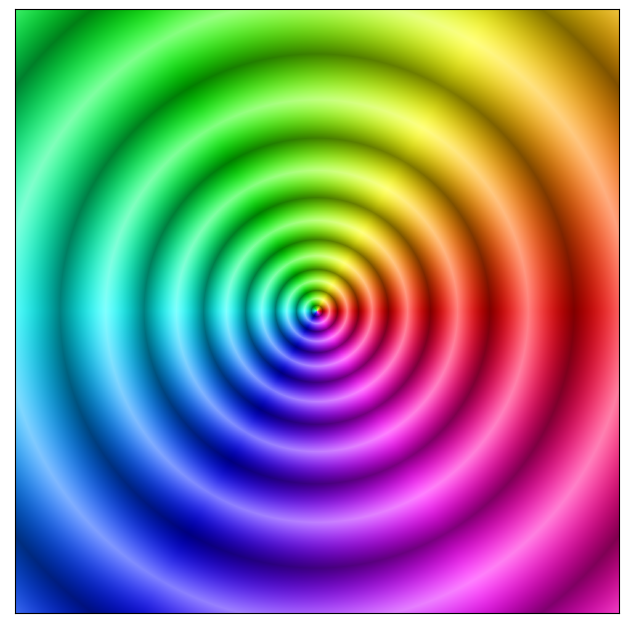

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
from matplotlib.colors import hsv_to_rgb

class DColor:
    def __init__(self, samples=3500, xmin=-10, xmax=10, ymin=-10, ymax=10):
        #plot settings
        self._samples = samples
        #axes
        self._xmin = xmin
        self._xmax = xmax
        self._ymin = ymin
        self._ymax = ymax
        self.makeDomain()

    def makeDomain(self):
        """Create the domains for Real (x) and Imaginary (y) values respectively"""
        x = np.linspace(self._xmin, self._xmax, self._samples)
        y = np.linspace(self._ymin, self._ymax, self._samples)
        self.xx, self.yy=np.meshgrid(x,y)

    def makeColorModel(self, zz):
        """Create the HSV color model for the function domain that will be plotted"""
        H = self.normalize(np.angle(zz) % (2. * np.pi)) #Hue determined by arg(z)
        r = np.log2(1. + np.abs(zz))
        S = (1. + np.abs(np.sin(2. * np.pi * r))) / 2.
        V = (1. + np.abs(np.cos(2. * np.pi * r))) / 2.

        return H,S,V

    def normalize(self, arr):
        """Used for normalizing data in array based on min/max values"""
        arrMin = np.min(arr)
        arrMax = np.max(arr)
        arr = arr - arrMin
        return arr / (arrMax - arrMin)

    def plot(self, f, xdim=10, ydim=8, plt_dpi=100):
        """Plot a complex-valued function
            Arguments:
            f -- a (preferably) lambda-function defining a complex-valued function
            Keyword Arguments:
            xdim -- x dimensions
            ydim -- y dimensions
            plt_dpi -- density of pixels per inch
        """
        zz=f(self.z(self.xx,self.yy))
        H,S,V = self.makeColorModel(zz)
        rgb = hsv_to_rgb(np.dstack((H,S,V)))

        fig = plt.figure(figsize=(xdim, ydim), dpi=plt_dpi)
        plt.imshow(rgb)
        plt.gca().invert_yaxis() #make CCW orientation positive
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
        plt.show()

    def z(self, x, y):
        """return complex number x+iy
            If inputs are arrays, then it returns an array with corresponding x_j+iy_j values
        """
        return x+1j*y

dc = DColor(xmin=-10, xmax=10, ymin=-10, ymax=10, samples=4000)
#dc.plot(lambda z : (z**5+1j*z**4+z**3+1j*z**2+z+1j+1)/np.sin(z))
#dc.plot(lambda z : 2j*z**2+2j+z)
#dc.plot(lambda z : (1/(1-1j*z))-(1+1j*z))
#dc.plot(lambda z : z**3)
#dc.plot(lambda z : ((z+1-2j)*(z+2+2j)*((z-2)**2))/(z**3))
dc.plot(lambda z : z)

C:\Users\rache\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


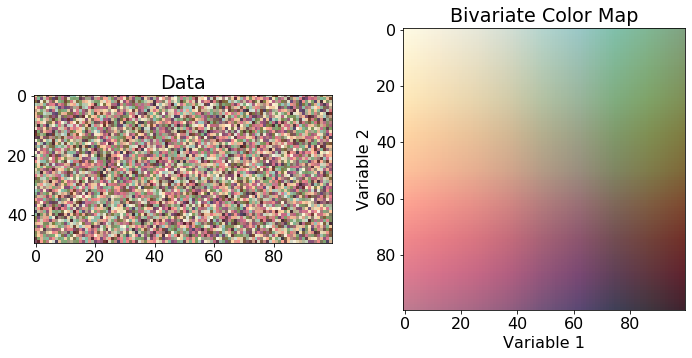

In [54]:


z1 = np.random.random((50,100))
z2 = np.random.random((50,100))
Z_color = colorFromBivariateData(z1,z2)

xx, yy = np.mgrid[0:100,0:100]
C_map = colorFromBivariateData(xx,yy)

fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(1,2,1)
ax1.imshow(Z_color)
ax1.set_title('Data')

ax2 = fig.add_subplot(1,2,2)
ax2.imshow(C_map)
ax2.set_title('Bivariate Color Map')
ax2.set_xlabel('Variable 1')
ax2.set_ylabel('Variable 2')

fig.tight_layout()
fig.show()